In [48]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy.orm import Session
from sqlalchemy import desc
from sqlalchemy import asc
from datetime import datetime, timedelta
from random import random

In [12]:
import numpy as np
import pandas as pd

# Reflect Tables into SQLAlchemy ORM

In [13]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [14]:
database_path = "Resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{database_path}")

In [15]:
# Reflect an existing database into a new model
Base = automap_base()
# Reflect the tables
Base.prepare(engine, reflect=True)

In [16]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [17]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [18]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

In [19]:
# Create a "Metadata" Layer That Abstracts SQL Database
# -----------------------------------------------------
Base.metadata.create_all(engine)

In [20]:
# Create a Session Object to Connect to DB
# ----------------------------------------
session = Session(bind=engine)

# Exploratory Climate Analysis

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Build the data frame with the 12 months of Measurement data

# Calculate the last data point from the list of Measurements
last_data_point = engine.execute("SELECT MAX(date) FROM Measurement ORDER BY date desc")
for rec in last_data_point:
    latest_date = rec
latest_date[0]

# Convert the last data point result from string to datetime format
latestresult = datetime.strptime(latest_date[0], '%Y-%m-%d')

# Calculate the date 12 months ago from the last data point
one_year_ago = latestresult - timedelta(days = 365)

measures = []
for measure in session.query(Measurement).filter(Measurement.date<=latestresult,Measurement.date>=one_year_ago).order_by(desc('date')):
     #print(measure.date, measure.prcp)
     measures_data = {'Station': [measure.station], 'Date': [measure.date], 'Prcp': [measure.prcp], 'Tobs': [measure.tobs]}
     measure_df = pd.DataFrame(data=measures_data)
     measures.append(measure_df)

measures_df = pd.concat(measures)
measures_df.head()


,Station,Date,Prcp,Tobs
0,USC00519397,2017-08-23,0.00,81.0
0,USC00514830,2017-08-23,0.00,82.0
0,USC00519523,2017-08-23,0.08,82.0
0,USC00516128,2017-08-23,0.45,76.0
0,USC00519397,2017-08-22,0.00,82.0


Text(0.5, 0, 'Date')

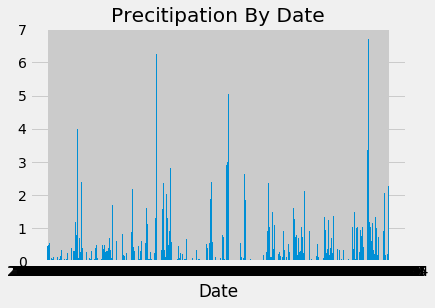

In [22]:
# Use Pandas Plotting with Matplotlib to plot the data

plt.bar(measures_df["Date"],measures_df["Prcp"],align="center",orientation="vertical")
plt.show
# Give the chart a title, x label, and y label
plt.title("Precitipation By Date")
plt.xlabel("Date")

In [23]:
# Use Pandas to calculate the summary statistics for the precipitation data
measures_summary = measures_df.groupby(['Station'])
total_prcp = measures_summary['Prcp'].sum()
min_prcp = measures_summary['Prcp'].min()
max_prcp = measures_summary['Prcp'].max()
avg_prcp = measures_summary['Prcp'].mean()
min_temp = measures_summary['Tobs'].min()
max_temp = measures_summary['Tobs'].max()
avg_temp = measures_summary['Tobs'].mean()
max_prcp

Station
USC00513117    2.90
USC00514830    2.39
USC00516128    6.70
USC00517948    2.40
USC00519281    2.98
USC00519397    2.62
USC00519523    6.25
Name: Prcp, dtype: float64

In [24]:
measures_summary_by_date = measures_df.groupby(['Station','Date'])
total_prcp_by_date = measures_summary_by_date['Prcp'].sum()
min_prcp_by_date = measures_summary_by_date['Prcp'].min()
max_prcp_by_date = measures_summary_by_date['Prcp'].max()
avg_prcp_by_date = measures_summary_by_date['Prcp'].mean()
min_temp_by_date = measures_summary_by_date['Tobs'].min()
max_temp_by_date = measures_summary_by_date['Tobs'].max()
avg_temp_by_date = measures_summary_by_date['Tobs'].mean()

![describe](Images/describe.png)

In [25]:
# Design a query to show how many stations are available in this dataset?
station_count = engine.execute("SELECT COUNT(station) FROM Station")
for rec in station_count:
    stations = rec
stations[0]

9

In [26]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = engine.execute("SELECT station, COUNT(station) FROM Measurement GROUP BY station ORDER BY COUNT(station) DESC")
for rec in active_stations:
    print(rec)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [27]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
active_temp = engine.execute("SELECT x.MinTemp, x.MaxTemp, x.AvgTemp, MAX(x.StationCount) FROM (SELECT MIN(tobs) AS MinTemp, MAX(tobs) AS MaxTemp, AVG(tobs) AS AvgTemp, COUNT(station) AS StationCount FROM Measurement GROUP BY station)x")
for rec in active_temp:
    print(rec)

(54.0, 85.0, 71.66378066378067, 2772)


In [28]:
avg_temp_list = engine.execute("SELECT MIN(tobs) AS MinTemp, MAX(tobs) AS MaxTemp, AVG(tobs) AS AvgTemp FROM Measurement WHERE date >= '2016-08-18' AND date <= '2017-08-18'")
for rec in avg_temp_list:
    print(rec)

(58.0, 87.0, 74.59875167186803)


In [29]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_temp = engine.execute("SELECT x.station, MAX(x.MaxTemp) FROM (SELECT station, COUNT(tobs) AS MaxTemp FROM Measurement GROUP BY station)x")
for rec in highest_temp:
    print(rec)

highest_station = rec[0]

('USC00519281', 2772)


In [30]:
# Calculate the last data point from the list of Measurements for this station
highest_data_point = engine.execute("SELECT MAX(date) FROM Measurement WHERE station = '" + highest_station + "' ORDER BY date desc")
for rec in highest_data_point:
    highest_date = rec
highest_date[0]

'2017-08-18'

In [31]:
# Convert the highest data point result from string to datetime format
highestresult = datetime.strptime(highest_date[0], '%Y-%m-%d')
print(highestresult)

2017-08-18 00:00:00


In [32]:
# Calculate the date 12 months ago from the highest data point
year_from_highest = highestresult - timedelta(days = 365)
print(year_from_highest)

2016-08-18 00:00:00


In [33]:
# Build the data frame with the 12 months of temperature data
temperatures = []
twelve_mo_data = engine.execute("SELECT date,tobs FROM Measurement WHERE station = '" + highest_station + "' AND date<= '" + highest_date[0] + "' AND date>= '" + str(year_from_highest) + "' ORDER BY date desc")
for rec in twelve_mo_data:
    #print(rec)
    temperatures_data = {'Date': [rec.date], 'Tobs': [rec.tobs]}
    temperature_df = pd.DataFrame(data=temperatures_data)
    temperatures.append(temperature_df)

temperatures_df = pd.concat(temperatures)
temperatures_df.head()


,Date,Tobs
0,2017-08-18,79.0
0,2017-08-17,76.0
0,2017-08-16,76.0
0,2017-08-15,77.0
0,2017-08-14,77.0


Text(0, 0.5, 'Frequency')

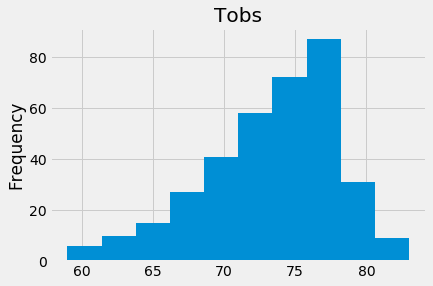

In [34]:
plt.hist(temperatures_df['Tobs'])
# Give the chart a title, x label, and y label
plt.title("Tobs")
plt.ylabel("Frequency")

In [36]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [37]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2011-02-28', '2011-03-05'))

[(61.0, 69.75510204081633, 75.0)]


<ErrorbarContainer object of 3 artists>

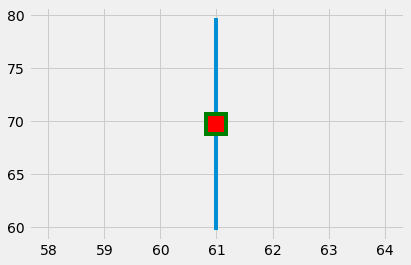

In [65]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Plot x versus y with error deltas in yerr and xerr. Vertical errorbars are plotted if yerr 
# is not None. Horizontal errorbars are plotted if xerr is not None.

plt.errorbar(61.0, 69.75510204081633, yerr=10, marker='s', mfc='red', mec='green', ms=20, mew=4)

In [66]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_data = engine.execute("SELECT DISTINCT rainfall.station AS station, rainfall.total_prcp AS TotalPrcp, stn.name AS Name, stn.latitude AS Lat, stn.longitude AS Long, stn.elevation AS Elevation FROM (SELECT measr.station, sum(prcp) as total_prcp FROM Measurement measr INNER JOIN Station statn ON measr.station = statn.station GROUP BY measr.station) rainfall INNER JOIN Station stn ON rainfall.station = stn.station INNER JOIN Measurement mnmt ON mnmt.station = stn.station AND mnmt.date<= '2011-03-05' AND mnmt.date>= '2011-02-28' ORDER BY TotalPrcp DESC")

rainfall = []
for rec in rainfall_data:
    precipitation_data = {'Station': [rec.station], 'TotalPrecip': [rec.TotalPrcp], 'Name': [rec.Name], 'Latitude': [rec.Lat], 'Longitude': [rec.Long], 'Elevation': [rec.Elevation]}
    precipitation_df = pd.DataFrame(data=precipitation_data)
    rainfall.append(precipitation_df)

precipitations_df = pd.concat(rainfall)
precipitations_df.head(50)


,Station,TotalPrecip,Name,Latitude,Longitude,Elevation
0,USC00516128,1068.09,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
0,USC00519281,588.64,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
0,USC00513117,382.62,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
0,USC00519523,295.68,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
0,USC00514830,234.49,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
0,USC00519397,131.62,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
0,USC00511918,92.68,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
0,USC00518838,70.87,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
0,USC00517948,43.44,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [67]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [41]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [42]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [43]:
# Plot the daily normals as an area plot with `stacked=False`
